# West Nile Virus Prediction - EDA

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
spray=pd.read_csv('spray.csv')
weather=pd.read_csv('weather.csv')

#### A new dataframe containig both train and test set

In [2]:
df1=pd.concat([train,test])

#### Make the 'Date' feature accecsible

In [3]:
#df1
df1['Year']=df1.Date.apply(lambda x: x[:4])
df1['Month']=df1.Date.apply(lambda x: x[5:7])
df1['Day']=df1.Date.apply(lambda x: x[8:10])
df1.drop(['Address','AddressNumberAndStreet'],axis=1,inplace=True)

#df2
df2=spray.copy()
df2['Year']=df2.Date.apply(lambda x: x[:4])
df2['Month']=df2.Date.apply(lambda x: x[5:7])
df2['Day']=df2.Date.apply(lambda x: x[8:10])

#df3
df3=weather.copy()
df3['Year']=df3.Date.apply(lambda x: x[:4])
df3['Month']=df3.Date.apply(lambda x: x[5:7])
df3['Day']=df3.Date.apply(lambda x: x[8:10])

#### Replace 'M' , '-' , 'T'

In [4]:
df3.drop('Water1',axis=1,inplace=True)
for col in df3.columns:
    dummy=df3[col][0]
    for ind in df3.index:
        if df3[col][ind]=='M':
            df3[col][ind]=dummy
        elif df3[col][ind]=='-':
            df3[col][ind]=dummy
        elif df3[col][ind]=='  T':
            df3[col][ind]=0.05  
            dummy=df3[col][ind]

#### Object to float64

In [5]:
catcol=df3.select_dtypes(include='object').columns
catcols=catcol.drop(['CodeSum','Date'])
df3[catcols]=df3[catcols].astype('float64')

#### Averaging the features of weather dataset

The weather influence on musquito presence in not of one day but the averge of past 3 days

In [6]:
avgcol=['Tmax','Tmin','Tavg','Depart','DewPoint','WetBulb','Heat','Cool','Sunrise','Sunset','Depth','SnowFall','PrecipTotal','StnPressure','SeaLevel','ResultSpeed','ResultDir','AvgSpeed']
for ind in range(len(df3)-1,3,-1):
    for col in avgcol:
        df3[col][ind]=((df3[col][ind]*50)+(df3[col][ind-1]*30)+(df3[col][ind-2]*20))/100

#### Finding the nearest station

In [7]:
df1['Decide']=((df1.Latitude>41.92)*1)*((df1.Longitude<(-87.75))*1)
df1.Decide=((df1.Decide-1)*(-1))+1

#### To merge train and weather datasets we need an unique feature which matches row of weather and train data set

In [8]:
df3['Match']=(100000*df3.Year)+(1000*df3.Month)+(df3.Day*10)+df3.Station
df1[['Year','Month','Day','Decide']]=df1[['Year','Month','Day','Decide']].astype('int64')
df1['Match']=(100000*df1.Year)+(1000*df1.Month)+(df1.Day*10)+df1.Decide

In [9]:
df4=df1.merge(df3,on='Match',how='left')
df4=df4.drop(['Date_x','Date_y','Year_x','Month_x', 'Day_x','Station','Decide','Match','Id','CodeSum'],axis=1)
df4.rename(columns={'Year_y':'Year','Month_y':'Month','Day_y':'Day'},inplace=True)

In [10]:
df4.Trap=df4.Trap.apply(lambda x:x[1:])

In [11]:
intcol=df4.select_dtypes(include=['int64','float64']).columns
catcol=df4.select_dtypes(include='object').columns

#### Import Seaborn Packages

In [12]:
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(20,10))

## 1.Univariate Analysis

### 1.1.Distplot

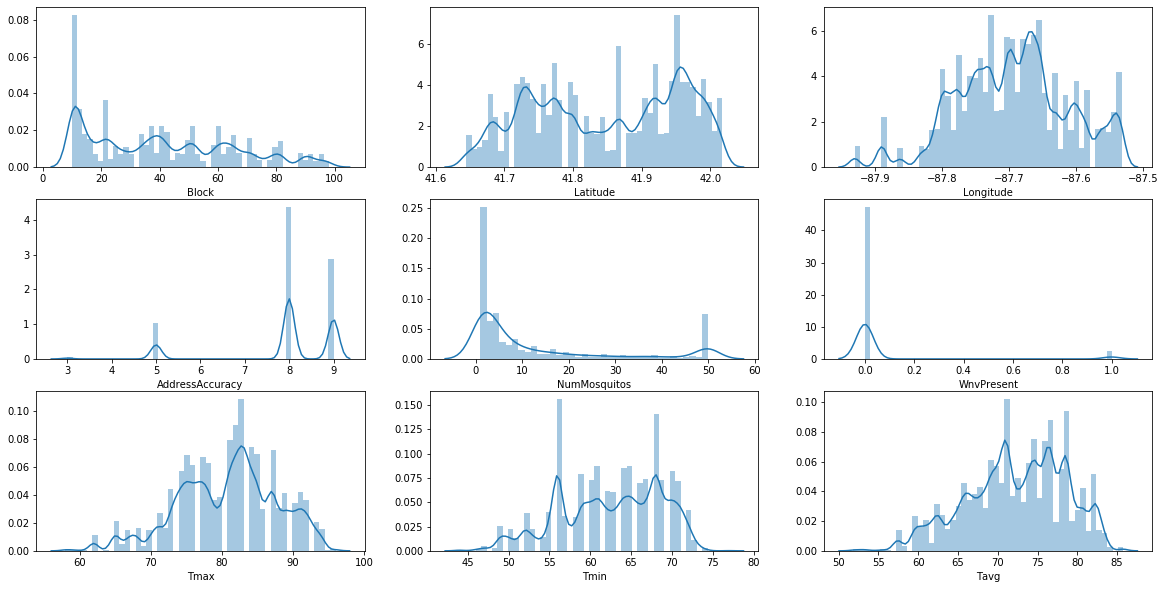

In [13]:
fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(20,10))
i=0
j=0
for col in intcol:
    sns.distplot(df4[col],ax=ax[i][j])
    intcol=intcol.drop(col)
    j=j+1
    if j==3:
        j=0
        i=i+1
    if i==3:
        break
    

1. Block,AddressAccuracy is  categorical variable.
2. Most traps capture less mosquitoes (<3). (target)
3. Most of the captured mosquitoes does not have the WNVirus. (target)
4. Tavg is left skewed.

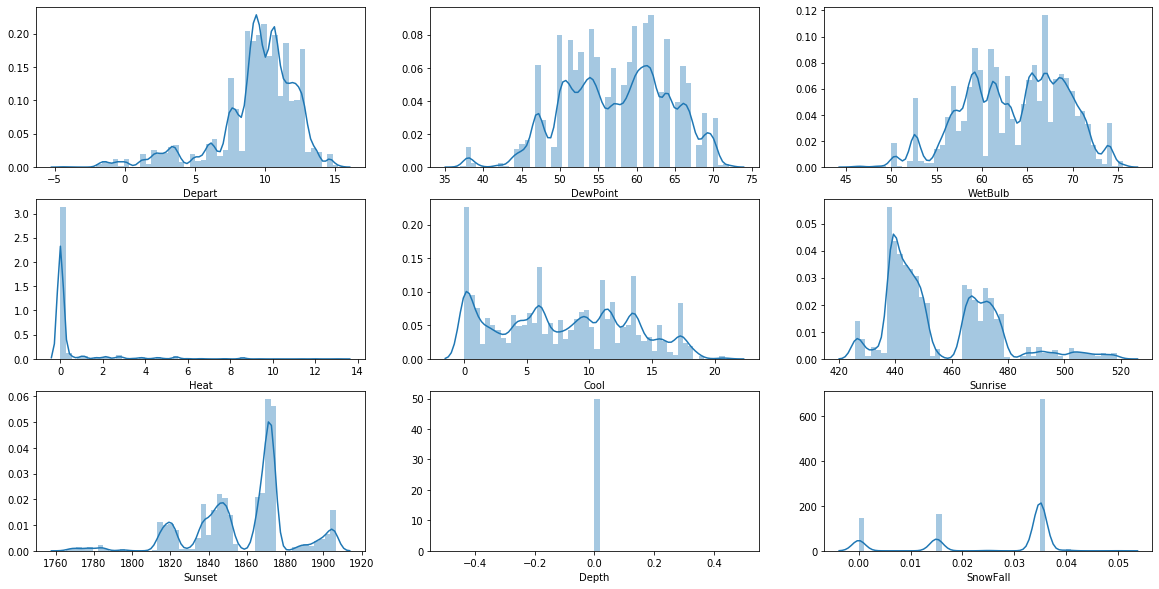

In [14]:
fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(20,10))
i=0
j=0
for col in intcol:
    sns.distplot(df4[col],ax=ax[i][j])
    intcol=intcol.drop(col)
    j=j+1
    if j==3:
        j=0
        i=i+1
    if i==3:
        break
    

1. Depart,Sunset is left skewed. SQRT transform
2. Heat,Sunrise is right skewed. LOG transform

9


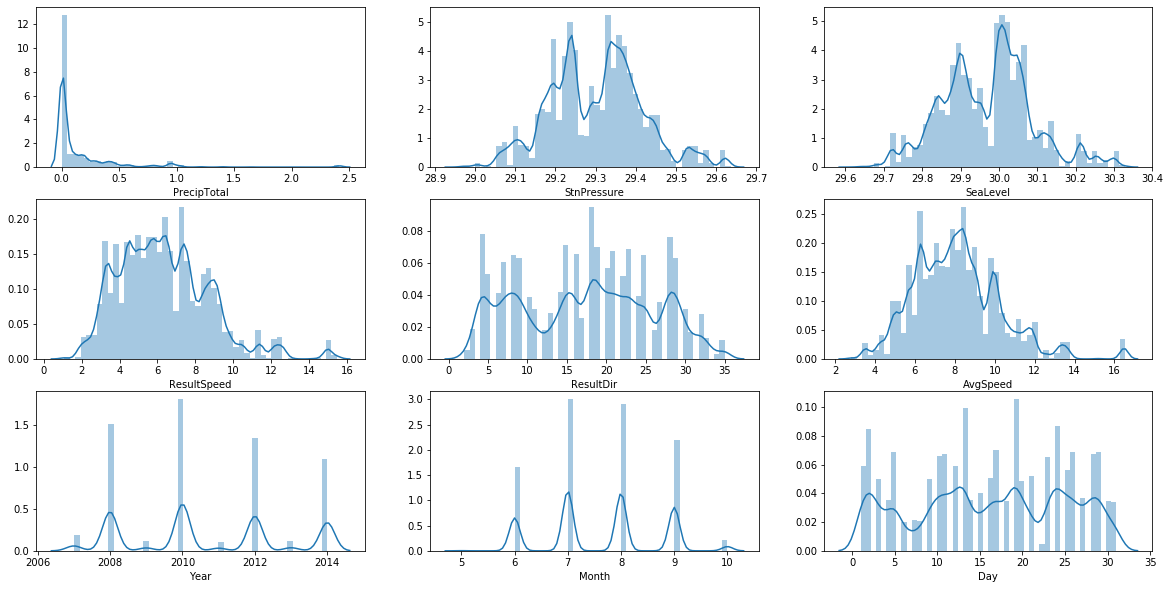

In [15]:
fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(20,10))
print(len(intcol))
i=0
j=0
for col in intcol:
    sns.distplot(df4[col],ax=ax[i][j])
    intcol=intcol.drop(col)
    j=j+1
    if j==3:
        j=0
        i=i+1
    if i==3:
        break


1. PrecipTotal is right skewed. LOG transformation
2. Less samples in odd year(train data),more samples in even year.(test data)

In [16]:
from scipy.stats import skew 
import numpy as np

# Lets drop all the numerical features which looks categorical in nature
intcol=df4.select_dtypes(include=['int64','float64']).columns
intcol=intcol.drop(['Block','AddressAccuracy','Year','Month','Day','NumMosquitos','WnvPresent'])

for col in intcol:
    if np.abs(skew(df4[col]))>0.3:
        print(skew(df4[col]),'-',col)

-0.3272165290258124 - Tmax
-0.36198280856466925 - Tmin
-0.3594885636568732 - Tavg
-1.4015457451694766 - Depart
3.9100722690022676 - Heat
0.934803906554468 - Sunrise
-0.6034155377378674 - Sunset
-1.1200942196777286 - SnowFall
3.999668560416814 - PrecipTotal
0.7629844344072545 - ResultSpeed
0.7473313792273455 - AvgSpeed


### 1.2.Boxplot

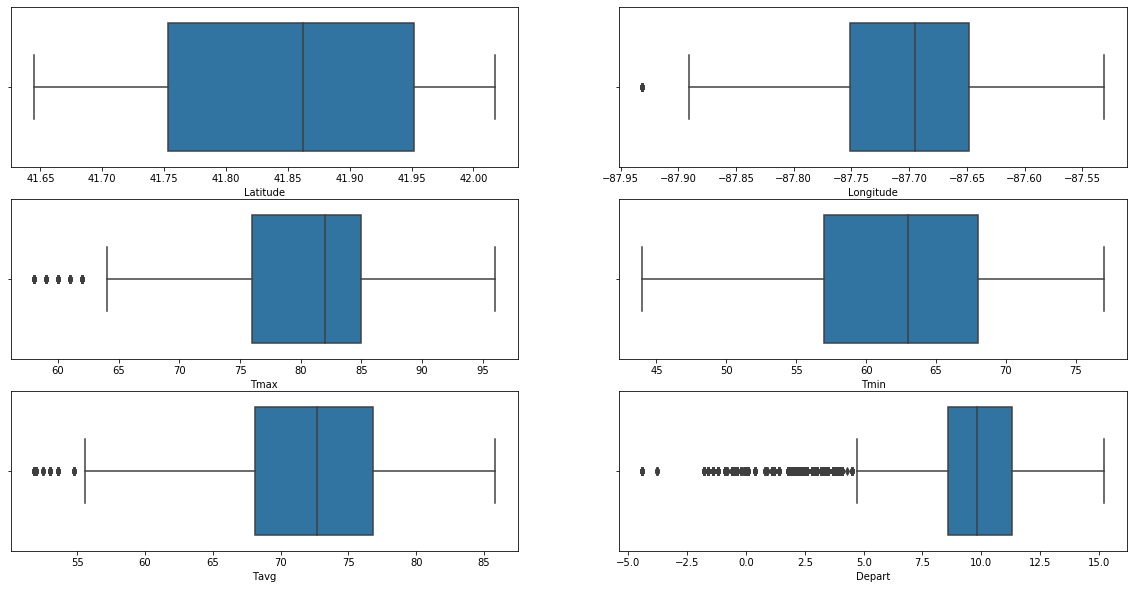

In [17]:
fig,ax=plt.subplots(nrows=3,ncols=2,figsize=(20,10))
i=0
j=0
for col in intcol:
    sns.boxplot(df4[col],ax=ax[i][j])
    intcol=intcol.drop(col)
    j=j+1
    if j==2:
        j=0
        i=i+1
    if i==3:
        break
    

1. So many outliers in the case of Depart. Will need both transformation and binning
2. Other feature's outliers can be treated by binning.

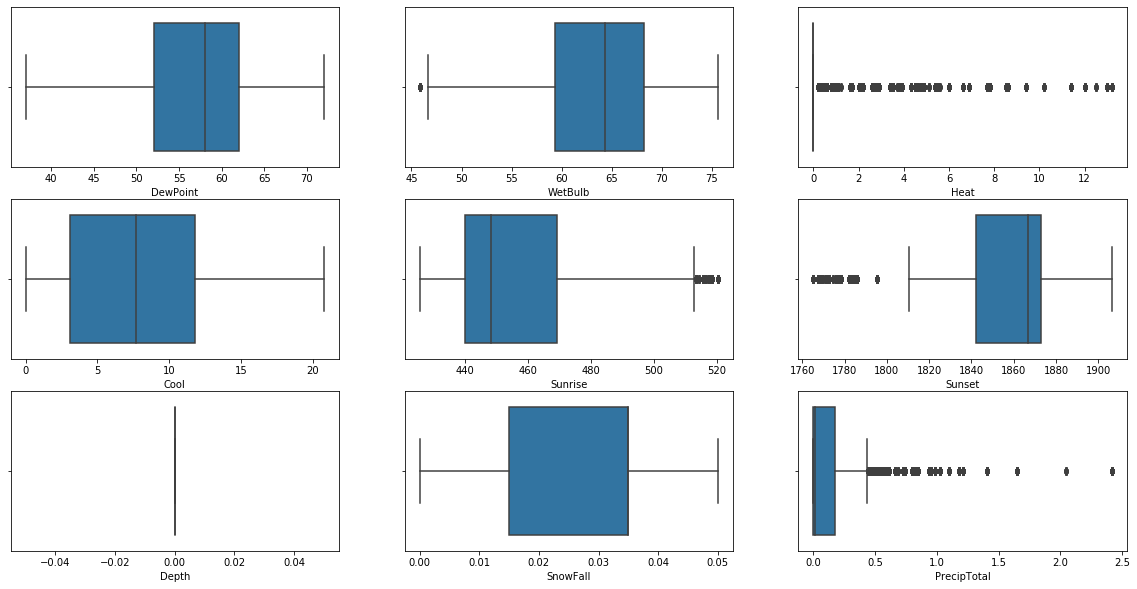

In [18]:
fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(20,10))
i=0
j=0
for col in intcol:
    sns.boxplot(df4[col],ax=ax[i][j])
    intcol=intcol.drop(col)
    j=j+1
    if j==3:
        j=0
        i=i+1
    if i==3:
        break
    

1. Many of these features require transformation and binning
2. Guess Depth is a dummy/null feature.
3. Heat feature contains a lot of 0s

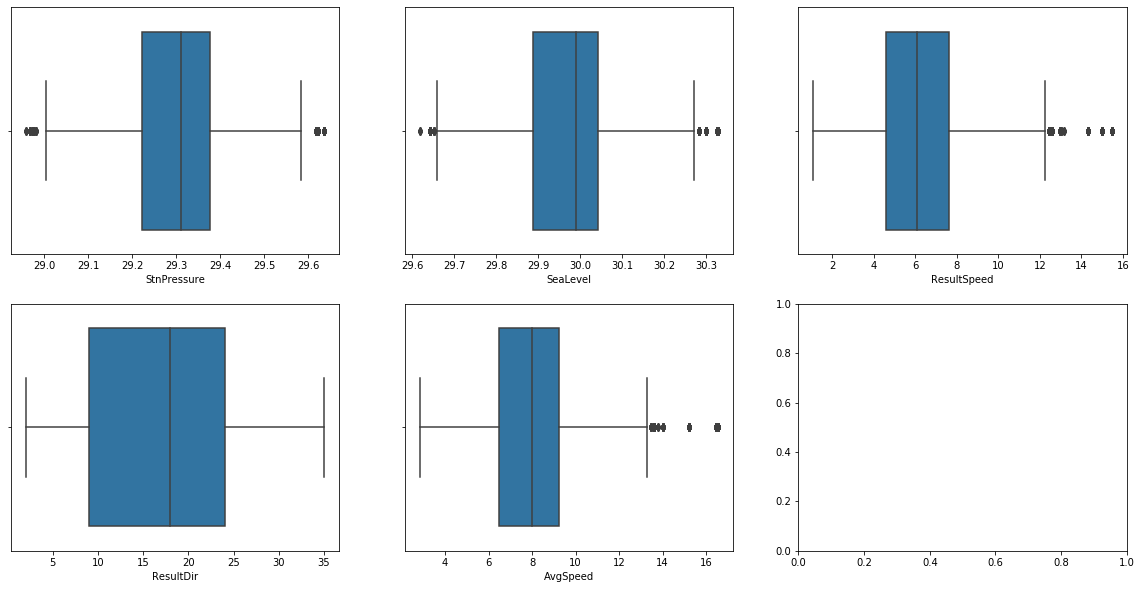

In [19]:
fig,ax=plt.subplots(nrows=2,ncols=3,figsize=(20,10))
i=0
j=0
for col in intcol:
    sns.boxplot(df4[col],ax=ax[i][j])
    intcol=intcol.drop(col)
    j=j+1
    if j==3:
        j=0
        i=i+1
    if i==2:
        break
    

Not many outliers, binning will be sufficient.

In [20]:
# Lets drop all the numerical features which looks categorical in nature
intcol=df4.select_dtypes(include=['int64','float64']).columns
intcol=intcol.drop(['Block','AddressAccuracy','Year','Month','Day','NumMosquitos','WnvPresent'])

## 2.Bivariate Analysis

### 2.1.Scatterplot

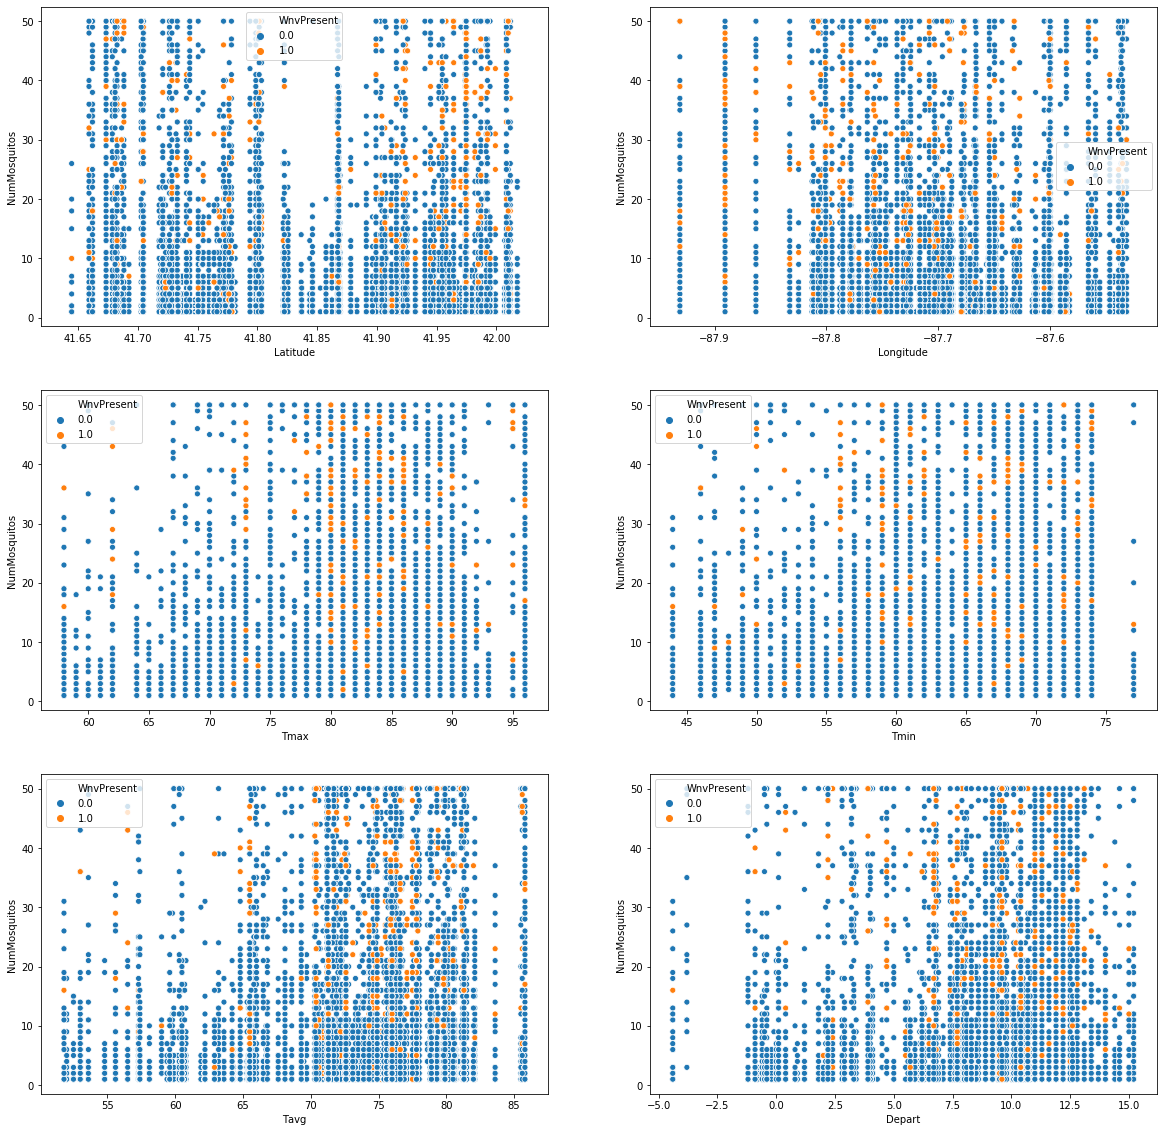

In [21]:
fig,ax=plt.subplots(nrows=3,ncols=2,figsize=(20,20))
i=0
j=0
for col in intcol:
    sns.scatterplot(x=df4[col],y=df4.NumMosquitos,hue=df4.WnvPresent,ax=ax[i][j])
    intcol=intcol.drop(col)
    j=j+1
    if j==2:
        j=0
        i=i+1
    if i==3:
        break
    

1. Latitude>41.90 has more WNVirus
2. More the temperature, more mosquitos caught, More WNVirus

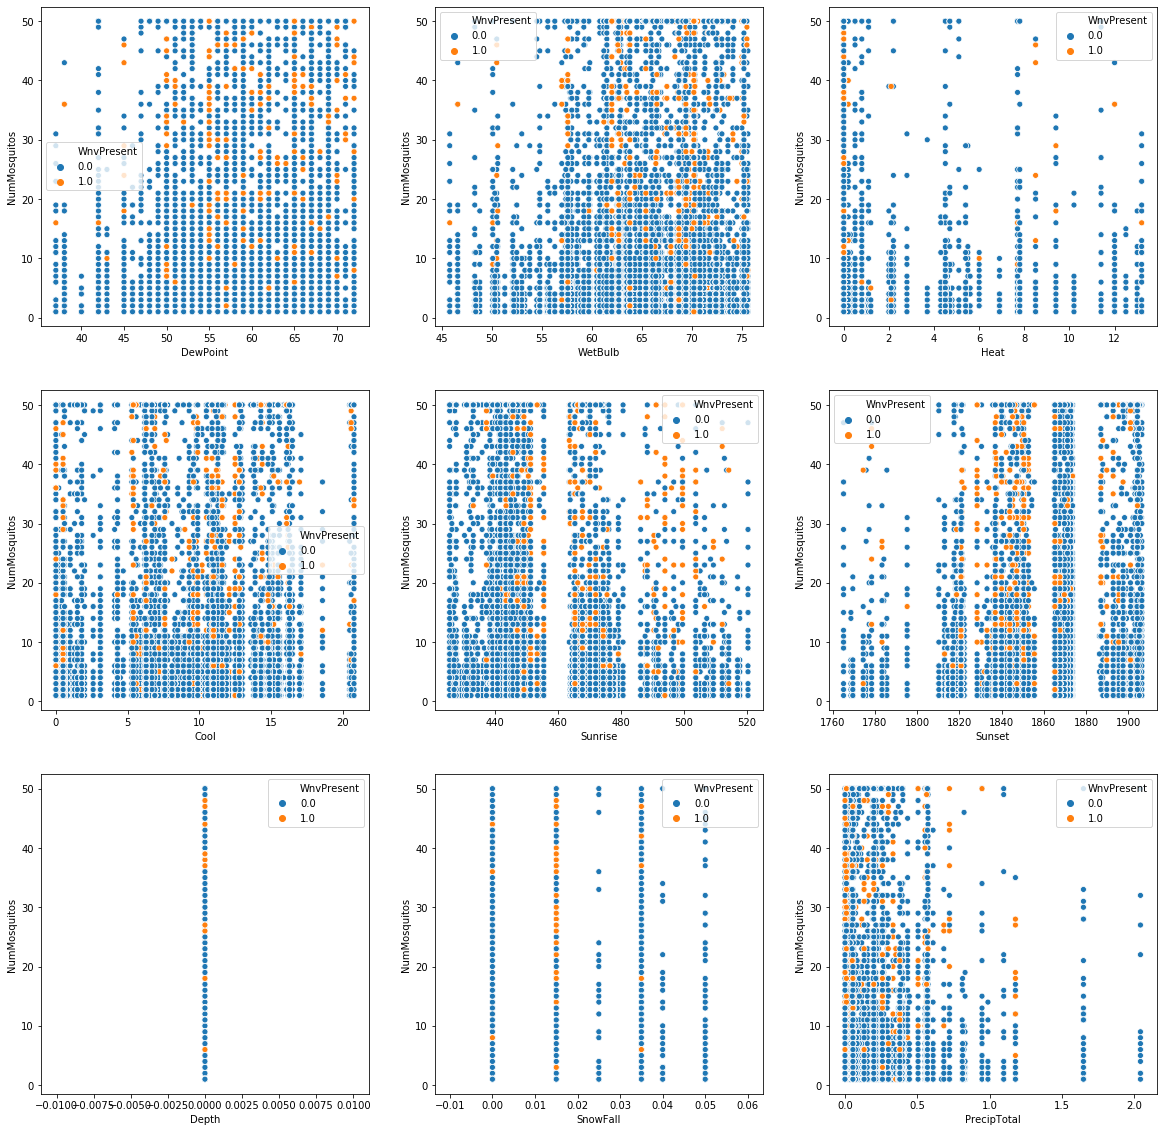

In [22]:
fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(20,20))
i=0
j=0
for col in intcol:
    sns.scatterplot(x=df4[col],y=df4.NumMosquitos,hue=df4.WnvPresent,ax=ax[i][j])
    intcol=intcol.drop(col)
    j=j+1
    if j==3:
        j=0
        i=i+1
    if i==3:
        break
    

1. More mosquitoos caught when 1820<SunSet<1860
2. 0.01<SnowFall<0.02 - more WNV

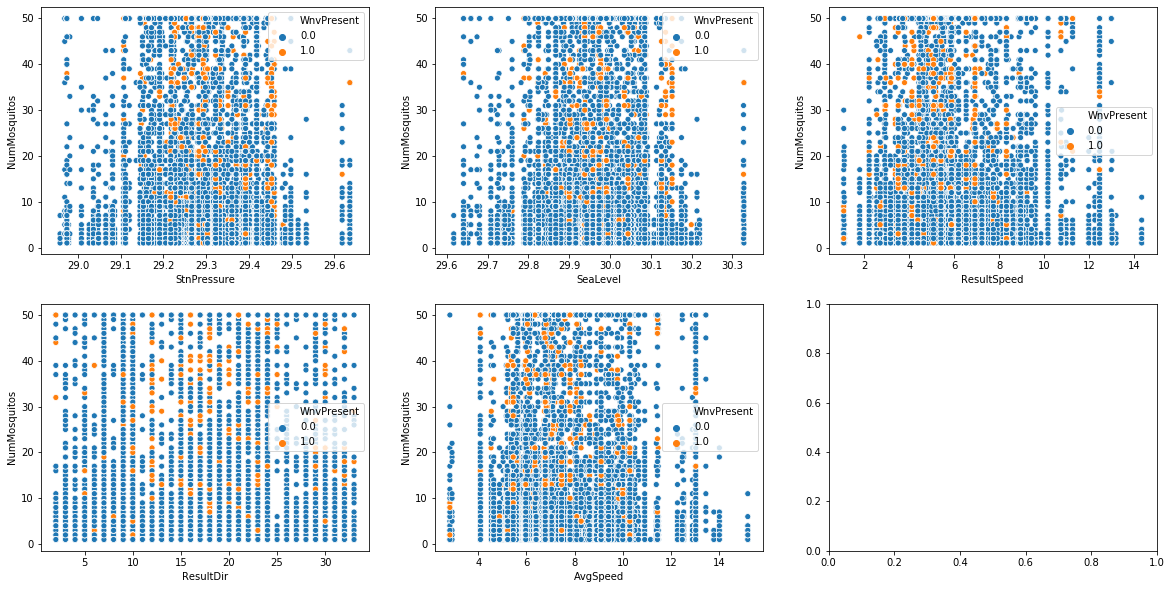

In [23]:
fig,ax=plt.subplots(nrows=2,ncols=3,figsize=(20,10))
i=0
j=0
for col in intcol:
    sns.scatterplot(x=df4[col],y=df4.NumMosquitos,hue=df4.WnvPresent,ax=ax[i][j])
    intcol=intcol.drop(col)
    j=j+1
    if j==3:
        j=0
        i=i+1
    if i==2:
        break
    

1. 30.1<SeaLevel<30.2 relatively many mosquitos caught have WNV

### HeatMap

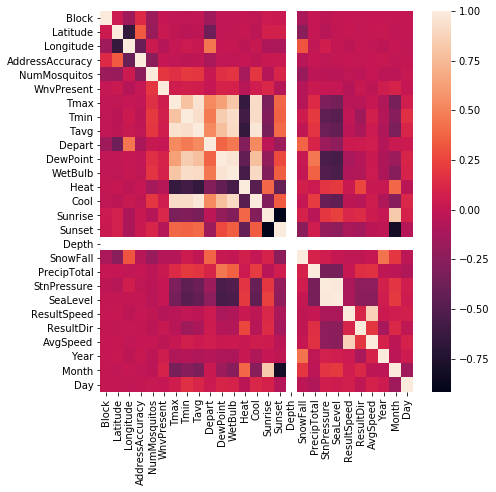

In [24]:
plt.figure(figsize=(7,7))
sns.heatmap(df4.corr())

#### Multicolinearity

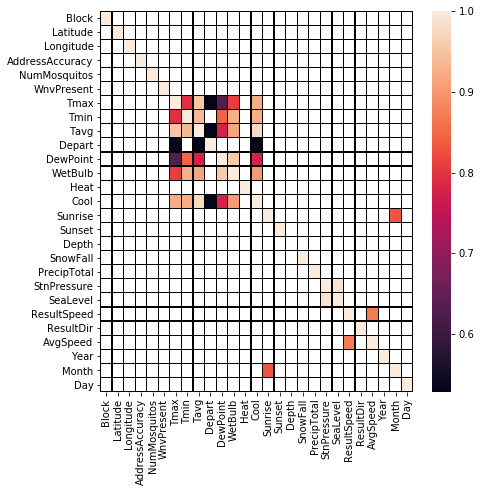

In [25]:
plt.figure(figsize=(7,7))
sns.heatmap(df4.corr()[df4.corr()>0.5],linewidths=.2, linecolor='black')

1. Tmax - Tmin,Tavg,Dewpoint,Cool
2. Tmin - Tavg,DewPoint,WetBulb,Cool
3. Tavg - WetBulb,Cool
4. DuePoint - WetBulb
5. WetBulb - Cool
6. Sunrise - Month
8. ResultSpeed - ResultDir

In [26]:
df4.corr().NumMosquitos.sort_values(ascending=False).head(30)

NumMosquitos       1.000000
Tmin               0.207821
WnvPresent         0.196820
Tavg               0.193925
Cool               0.193244
WetBulb            0.189047
Tmax               0.168216
DewPoint           0.167241
Sunset             0.116249
Longitude          0.036633
Depart             0.026276
Day                0.020451
AvgSpeed           0.011635
ResultSpeed       -0.010648
ResultDir         -0.025404
Month             -0.026040
Year              -0.029611
PrecipTotal       -0.031816
StnPressure       -0.034840
SeaLevel          -0.043922
Sunrise           -0.058867
Heat              -0.127769
Block             -0.172388
SnowFall          -0.182214
Latitude          -0.184806
AddressAccuracy   -0.248414
Depth                   NaN
Name: NumMosquitos, dtype: float64

In [27]:
df4.corr().WnvPresent.sort_values(ascending=False).head(30)

WnvPresent         1.000000
NumMosquitos       0.196820
Sunrise            0.122476
Month              0.100143
DewPoint           0.096398
WetBulb            0.090281
Tmin               0.078141
Tavg               0.067319
Cool               0.062630
Tmax               0.052721
Year               0.050865
Latitude           0.028697
PrecipTotal        0.027548
ResultDir          0.023560
SeaLevel           0.009258
Day                0.008245
AddressAccuracy    0.008064
StnPressure        0.006672
Depart             0.006598
Block              0.004877
AvgSpeed          -0.025380
Heat              -0.054310
ResultSpeed       -0.056900
Longitude         -0.060345
SnowFall          -0.061534
Sunset            -0.062184
Depth                   NaN
Name: WnvPresent, dtype: float64

Very few features which are highly correlated with target

### Countplot

In [28]:
catcol=df4.select_dtypes(include='object')

intcol=df4.select_dtypes(include=['int64','float64']).columns
intcol=intcol.drop(['Block','AddressAccuracy','Year','Month','Day','NumMosquitos','WnvPresent'])

catcol=df4.columns.drop(intcol)
for col in catcol:
    print(len(df4[col].unique()),'+',col)

8 + Species
65 + Block
139 + Street
149 + Trap
4 + AddressAccuracy
51 + NumMosquitos
3 + WnvPresent
8 + Year
6 + Month
31 + Day


Block,Street,Trap,NumMosquitos,Day contain way too many categories

In [29]:
catcol=catcol.drop(['WnvPresent','Block','Street','Trap','NumMosquitos','Day'])

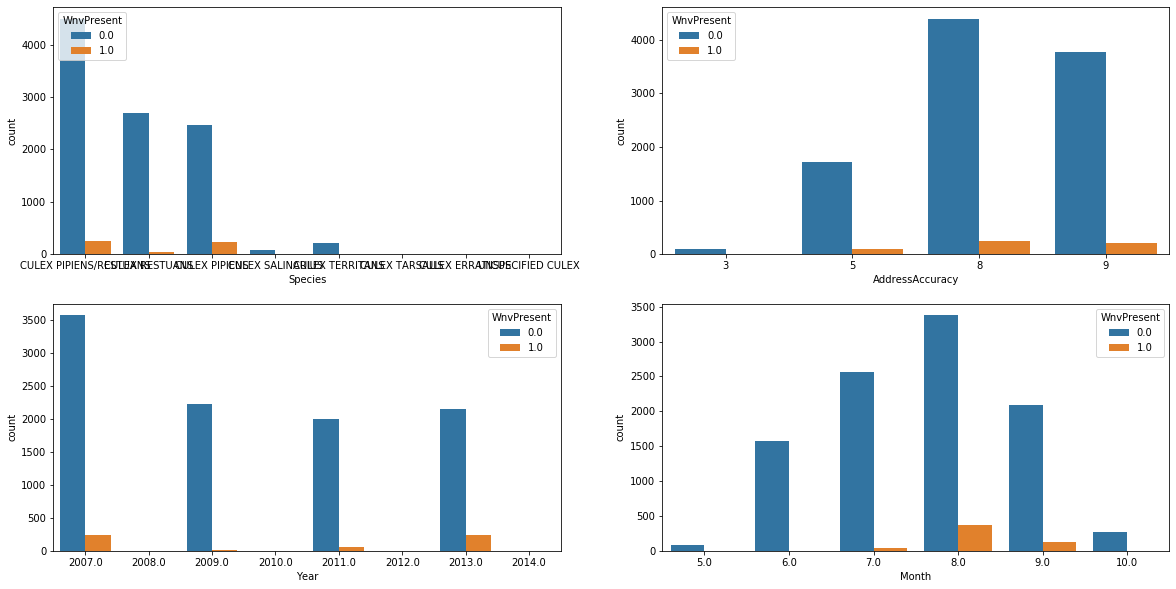

In [30]:
fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(20,10))
i=0
j=0
for col in catcol:
    sns.countplot(x=df4[col],hue=df4.WnvPresent,ax=ax[i][j])
    j=j+1
    if j==2:
        j=0
        i=i+1
    if i==2:
        break
    

1. CULEX PIPIENS/RESTUANS  is the most common species of mosquito, followed by CULEX RESTUANS,CULEX PIPIENS
2. Mosquito count increases in month 8

# West Nile Virus Prediction - Feature Engineering

#### Remove correlated features and unwanted features

In [31]:
#Correlated
df4.drop(['Tmax','Tavg','Cool','Sunrise','ResultDir','WetBulb','ResultSpeed'],axis=1,inplace=True)

#Unwanted
df4.drop(['Block','Street','Trap','Depth','AddressAccuracy','Heat'],axis=1,inplace=True)

In [32]:
intcol=df4.select_dtypes(include=['int64','float64']).columns

for col in intcol:
    if np.abs(skew(df4[col]))>0.3:
        print(skew(df4[col]),'-',col)

-0.36198280856466925 - Tmin
-1.4015457451694766 - Depart
-0.6034155377378674 - Sunset
-1.1200942196777286 - SnowFall
3.999668560416814 - PrecipTotal
0.7473313792273455 - AvgSpeed


#### Remove Skewness

In [33]:
leftskew=['Tmin','Sunset']
rightskew=['PrecipTotal','AvgSpeed']
df4.PrecipTotal=df4.PrecipTotal+.0001
for col in leftskew:
    df4[col]=np.sqrt(df4[col])
for col in rightskew:
    df4[col]=np.log(df4[col])
df4.Depart=df4.Depart*0.33

#### String categorical to integer

In [34]:
df5=pd.get_dummies(df4.Species)
df4 = df4.merge(df5, left_index=True, right_index=True)
df4.drop('Species',axis=1,inplace=True)

#### Clustering the traps

In [35]:
from sklearn.cluster import KMeans

kmeans = KMeans(30)
clusters = kmeans.fit_predict(df4[['Latitude','Longitude']])
df4['cluster'] = kmeans.predict(df4[['Latitude','Longitude']])

In [36]:
df4.head(1).transpose()

,0
Latitude,41.954690
Longitude,-87.800991
NumMosquitos,1.000000
WnvPresent,0.000000
Tmin,7.483315
Depart,3.168000
DewPoint,53.000000
Sunset,43.547675
SnowFall,0.000000
PrecipTotal,-4.595220


#### 1 new feature

In [37]:
df4['WNV']=((df4.Latitude>41.9)*1) + ((df4.SnowFall<0.02)*(df4.SnowFall>0.01)*1) + ((df4.SeaLevel<30.2)*(df4.SeaLevel>30.1)*1)

### Scaling and Normalization

In [38]:
from sklearn.preprocessing import MinMaxScaler
df5=pd.DataFrame(MinMaxScaler().fit_transform(df4))
df5.columns=df4.columns
df5.NumMosquitos=df4.NumMosquitos
df5.WnvPresent=df4.WnvPresent

In [39]:
df6=df5.copy()

In [40]:
bincol=['Tmin', 'Depart','DewPoint', 'Sunset', 'SnowFall', 'PrecipTotal', 'StnPressure','SeaLevel', 'AvgSpeed']
for col in bincol:
    val1=df6[col].quantile(0.90)
    val2=df6[col].quantile(0.10)
    for ind in df6.index:
        if df6[col][ind]>val1:
            df6[col][ind]=val1
        
        elif df6[col][ind]<val2:
            df6[col][ind]=val2

## Model Training

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

train=df6[df6.NumMosquitos.notna()]
train_x1=train.drop(['NumMosquitos','WnvPresent'],axis=1)
train_x2=train.drop(['WnvPresent'],axis=1)

train_y1=train.NumMosquitos
train_y2=train.WnvPresent

test=df6[df6.NumMosquitos.isna()]
test=test.drop(['NumMosquitos','WnvPresent'],axis=1)

tx1,vx1,ty1,vy1=train_test_split(train_x1,train_y2)
tx2,vx2,ty2,vy2=train_test_split(train_x2,train_y2)

from sklearn.linear_model import LogisticRegression

LR1=LogisticRegression(max_iter=100000)
LR1.fit(tx1,ty1)
predict=LR1.predict(vx1)
print(accuracy_score(vy1,predict))

LR2=LogisticRegression(max_iter=100000)
LR2.fit(tx2,ty2)
predict=LR2.predict(vx2)
print(accuracy_score(vy2,predict))

0.9440426341834792
0.947087933003426


Lets set this score as our base score and try to get a higher prediction rate.

### 1.Random Forest Classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier

RFC1 = RandomForestClassifier()
RFC1.fit(tx1,ty1)
predict=RFC1.predict(vx1)
print(accuracy_score(vy1,predict))

RFC2 = RandomForestClassifier()
RFC2.fit(tx2,ty2)
predict=RFC2.predict(vx2)
print(accuracy_score(vy2,predict))

0.9375713741910925
0.9444232965359726


### 2.XGBoost Classifier

In [43]:
from xgboost import XGBClassifier

XGB1 = XGBClassifier()
XGB1.fit(tx1,ty1)
predict=XGB1.predict(vx1)
print(accuracy_score(vy1,predict))

XGB2 = XGBClassifier()
XGB2.fit(tx2,ty2)
predict=XGB2.predict(vx2)
print(accuracy_score(vy2,predict))

0.9451846212409593
0.9436619718309859


### 3.KNN

In [44]:
from sklearn.neighbors import KNeighborsClassifier

for i in range(10,70,5):
    KNN1=KNeighborsClassifier(n_neighbors=i)
    KNN1.fit(tx1,ty1)
    predict=KNN1.predict(vx1)
    print(i,accuracy_score(vy1,predict))
    KNN2=KNeighborsClassifier(n_neighbors=i)
    KNN2.fit(tx2,ty2)
    predict=KNN2.predict(vx2)
    print(i,accuracy_score(vy2,predict))
    print('-')

10 0.9448039588884659
10 0.9459459459459459
-
15 0.9432813094784925
15 0.9478492577084127
-
20 0.9436619718309859
20 0.9486105824133994
-
25 0.9432813094784925
25 0.9486105824133994
-
30 0.9440426341834792
30 0.9486105824133994
-
35 0.9440426341834792
35 0.9486105824133994
-
40 0.9440426341834792
40 0.9486105824133994
-
45 0.9440426341834792
45 0.9486105824133994
-
50 0.9440426341834792
50 0.9486105824133994
-
55 0.9440426341834792
55 0.9486105824133994
-
60 0.9440426341834792
60 0.9486105824133994
-
65 0.9440426341834792
65 0.9486105824133994
-


Wierd, KNN = 30 and logistic regression are giving same output

So the prediction is better when the NumMosquitos is absent. And LogisticRegression/KNN performs better.We will go with Logistic Regression

In [45]:
test1=pd.read_csv('test.csv')
df_final=pd.DataFrame(test1.Id)
prediction=LR1.predict(test)
df_final.insert(1,'WnvPresent',prediction,True)
df_final.WnvPresent.value_counts()

0.0    116255
1.0        38
Name: WnvPresent, dtype: int64

In [46]:
df_final.to_csv('WNVP.csv',index=False)